In [1]:
# Import the libraries
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [2]:
### LOAD TRAIN ##
train_df = pd.read_csv('/Users/rahuljoshi/Desktop/DataScienceProblems/endtoendMLProjects/rulestimationusingcnn/data/PM_train.txt',
                       sep = " ", header= None)

train_df.drop(train_df.columns[[26,27]], axis=1, inplace =True)
train_df.columns = ['id', 'cycle', 'setting1','setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                    's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

print('#id:', len(train_df.id.unique()))
train_df = train_df.sort_values(['id', 'cycle'])
print(train_df.shape) 

#id: 100
(20631, 26)


In [3]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


medium working time: 206.31
max working time: 362
min working time: 128


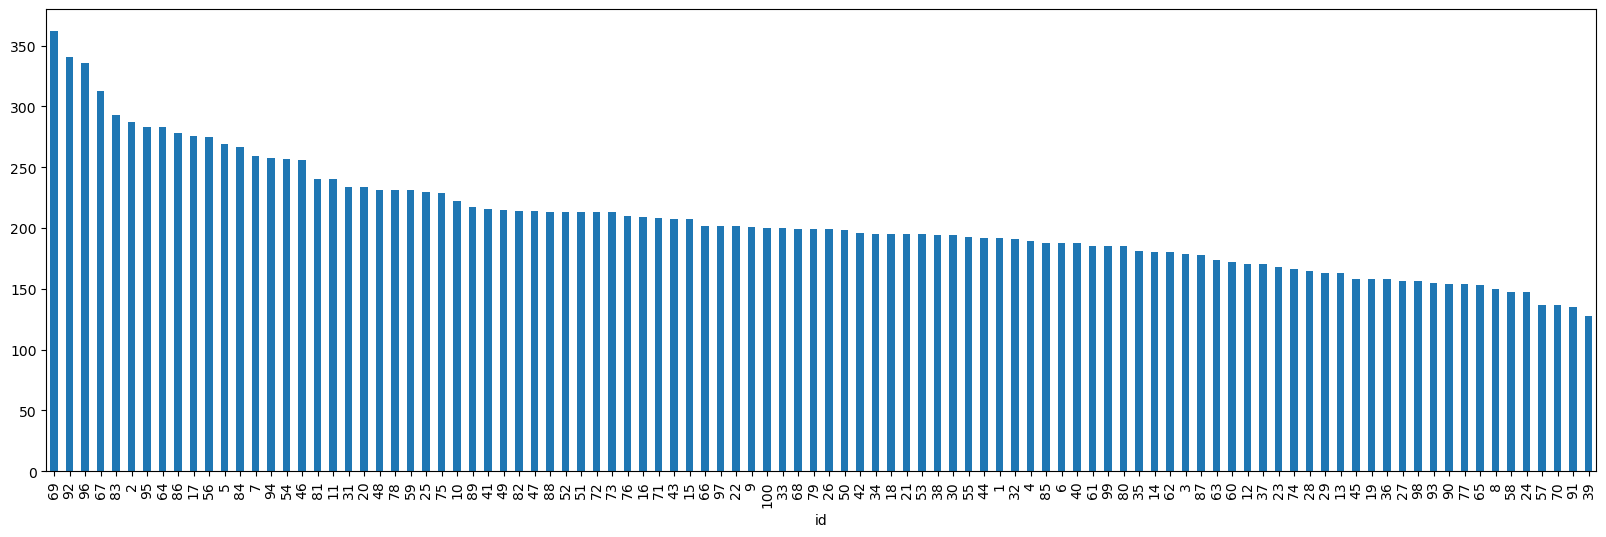

In [4]:
### PLOT TRAIN FREQ ###
plt.figure(figsize=(20,6))
train_df.id.value_counts().plot.bar()

print("medium working time:", train_df.id.value_counts().mean())
print("max working time:", train_df.id.value_counts().max())
print("min working time:", train_df.id.value_counts().min())

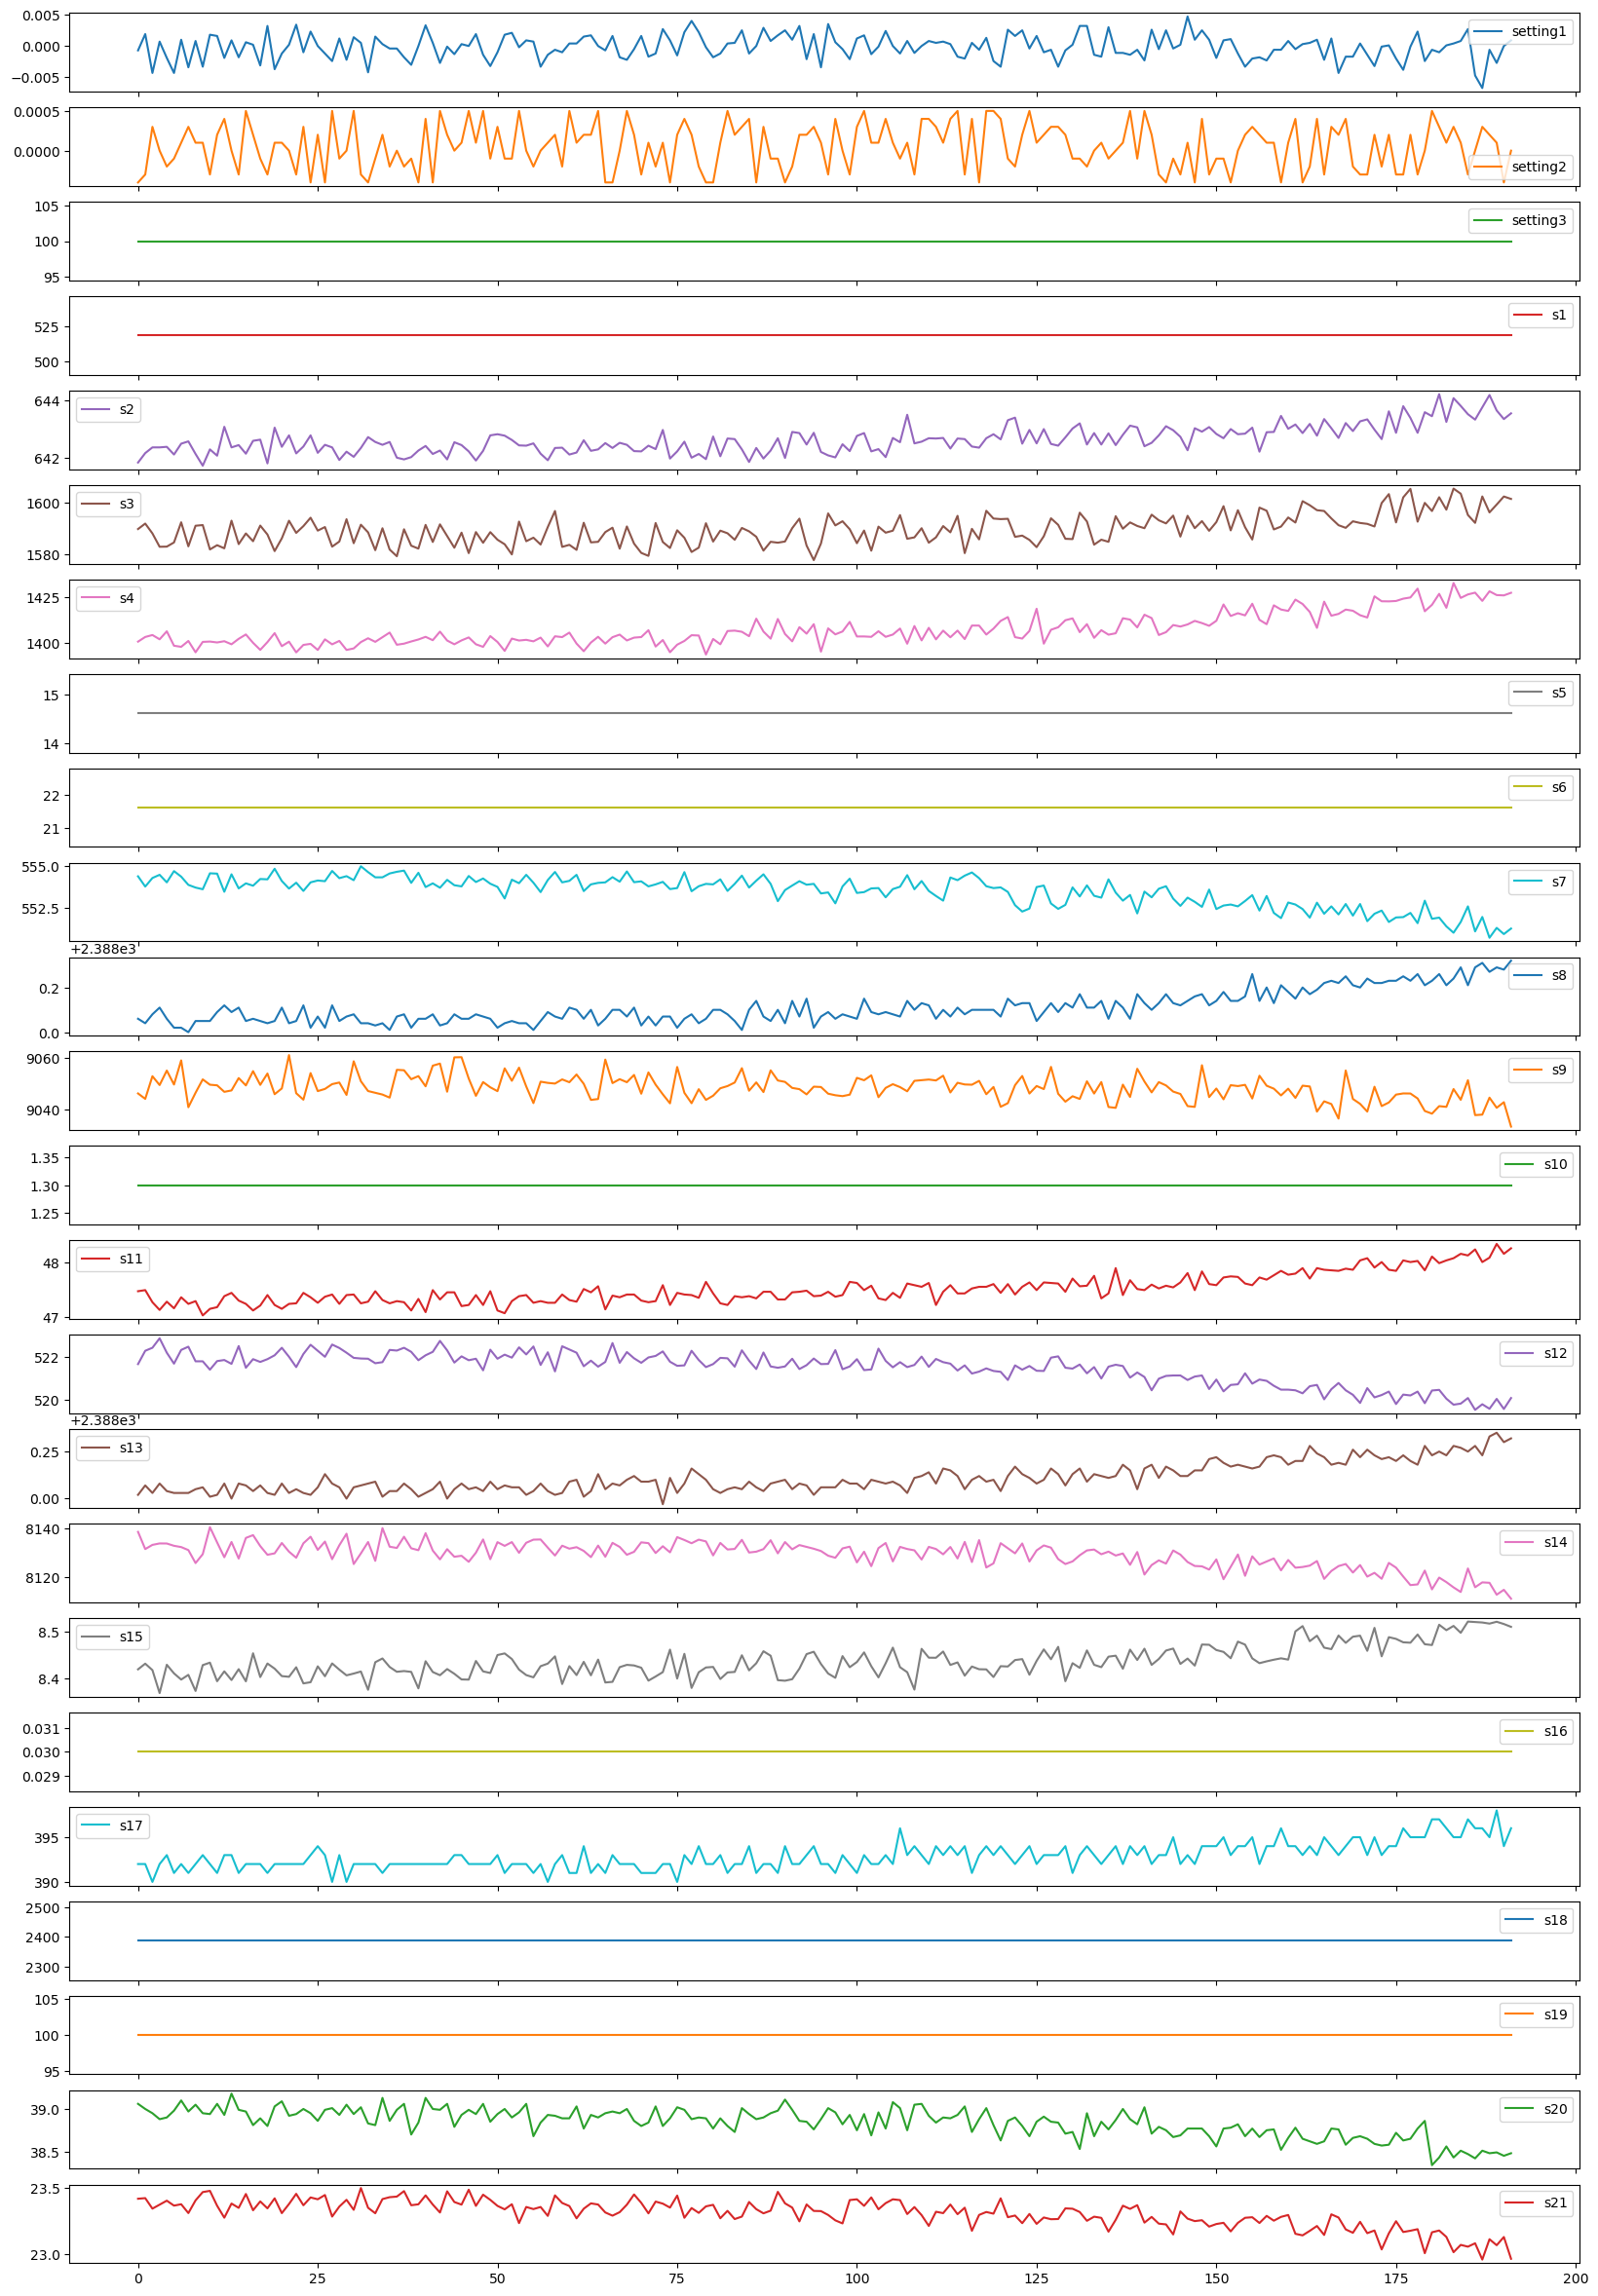

In [5]:
### plotting sensor data for engine ID ###
engine_id = train_df[train_df['id']==1]


ax1 = engine_id[train_df.columns[2:]].plot(subplots=True, sharex=True, figsize=(20,30))

In [6]:
### Load test ###
test_df = pd.read_csv('/Users/rahuljoshi/Desktop/DataScienceProblems/endtoendMLProjects/rulestimationusingcnn/data/PM_test.txt',
                       sep = " ", header = None)

test_df.drop(test_df.columns[[26,27]], axis =1, inplace=True)

test_df.columns = ['id', 'cycle', 'setting1','setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                    's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

print('#id:', len(test_df.id.unique()))
print(test_df.shape)

#id: 100
(13096, 26)


In [7]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [8]:
### Load ground truth ###
truth_df = pd.read_csv('/Users/rahuljoshi/Desktop/DataScienceProblems/endtoendMLProjects/rulestimationusingcnn/data/PM_truth.txt',
                       sep = " ", header= None)

truth_df.drop(truth_df.columns[[1]],axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head()

(100, 1)


,more
1,112
2,98
3,69
4,82
5,91


In [9]:
### Calculate RUL for training data ###
train_df['RUL'] = train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']

In [10]:
train_df.RUL[0:10]

0    191
1    190
2    189
3    188
4    187
5    186
6    185
7    184
8    183
9    182
Name: RUL, dtype: int64

In [11]:
train_df[train_df['id'] == 1].head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [12]:
### Add new label in training dataset ###
w1 = 45
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1,0)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2 

In [13]:
### Scale Train Data ###
def scale(df):
    return (df - df.min())/(df.max()-df.min())

for col in train_df.columns:
    if col[0] == 's':
        train_df[col] = scale(train_df[col])

train_df = train_df.dropna(axis=1)
train_df.head()


,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,...,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,...,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,...,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,...,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,...,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0


In [14]:
## Calculate RUL Test ##
truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']

In [15]:
## Add new label in testing data ##
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1,0)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2


In [16]:
### Scale Test Data  ###
for col in test_df.columns:
    if col[0] == 's':
        test_df[col] = scale(test_df[col])

test_df = test_df.dropna(axis=1)

In [17]:
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,...,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142,0,0
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,...,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141,0,0
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,...,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140,0,0
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,...,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139,0,0
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,...,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138,0,0


GEN SEQUENCE

In [18]:
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 (start stop) -> from row 0 to row 50
    # 1 51 (start stop) -> from row 1 to row 51
    # 2 52 (start stop) -> from row 2 to row 52
    # ...
    # 141 191 (start stop) -> from row 141 to 191
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


def gen_label(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [19]:
### Sequence Col : Columns to Consider ###
sequence_cols = []
for col in train_df.columns:
    if col[0] == 's':
        sequence_cols.append(col)

print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


In [20]:
### Generate X train test ###
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id == engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)

    for sequence in gen_sequence(test_df[test_df.id == engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)

In [21]:
x_train = np.asarray(x_train)
x_test  = np.asarray(x_test)
print("X_Train shape:", x_train.shape)
print("X_Test  shape:", x_test.shape)

X_Train shape: (15631, 50, 17)
X_Test  shape: (8162, 50, 17)


In [22]:
### Generate Y Train Test ###
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_label(train_df[train_df.id == engine_id], sequence_length, ['label2']):
        y_train.append(label)

    for label in gen_label(test_df[test_df.id == engine_id], sequence_length, ['label2']):
        y_test.append(label)

In [23]:
y_train = np.asarray(y_train).reshape(-1,1)
y_test  = np.asarray(y_test).reshape(-1,1)

In [24]:
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

y_train shape: (15631, 1)
y_test  shape: (8162, 1)


In [25]:
### Encode label ##
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train.shape)

y_test = tf.keras.utils.to_categorical(y_test)
print(y_test.shape)

(15631, 3)
(8162, 3)


FROM TIME SERIES TO IMAGES

In [26]:
def rec_plot(s, eps=0.1, steps =10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

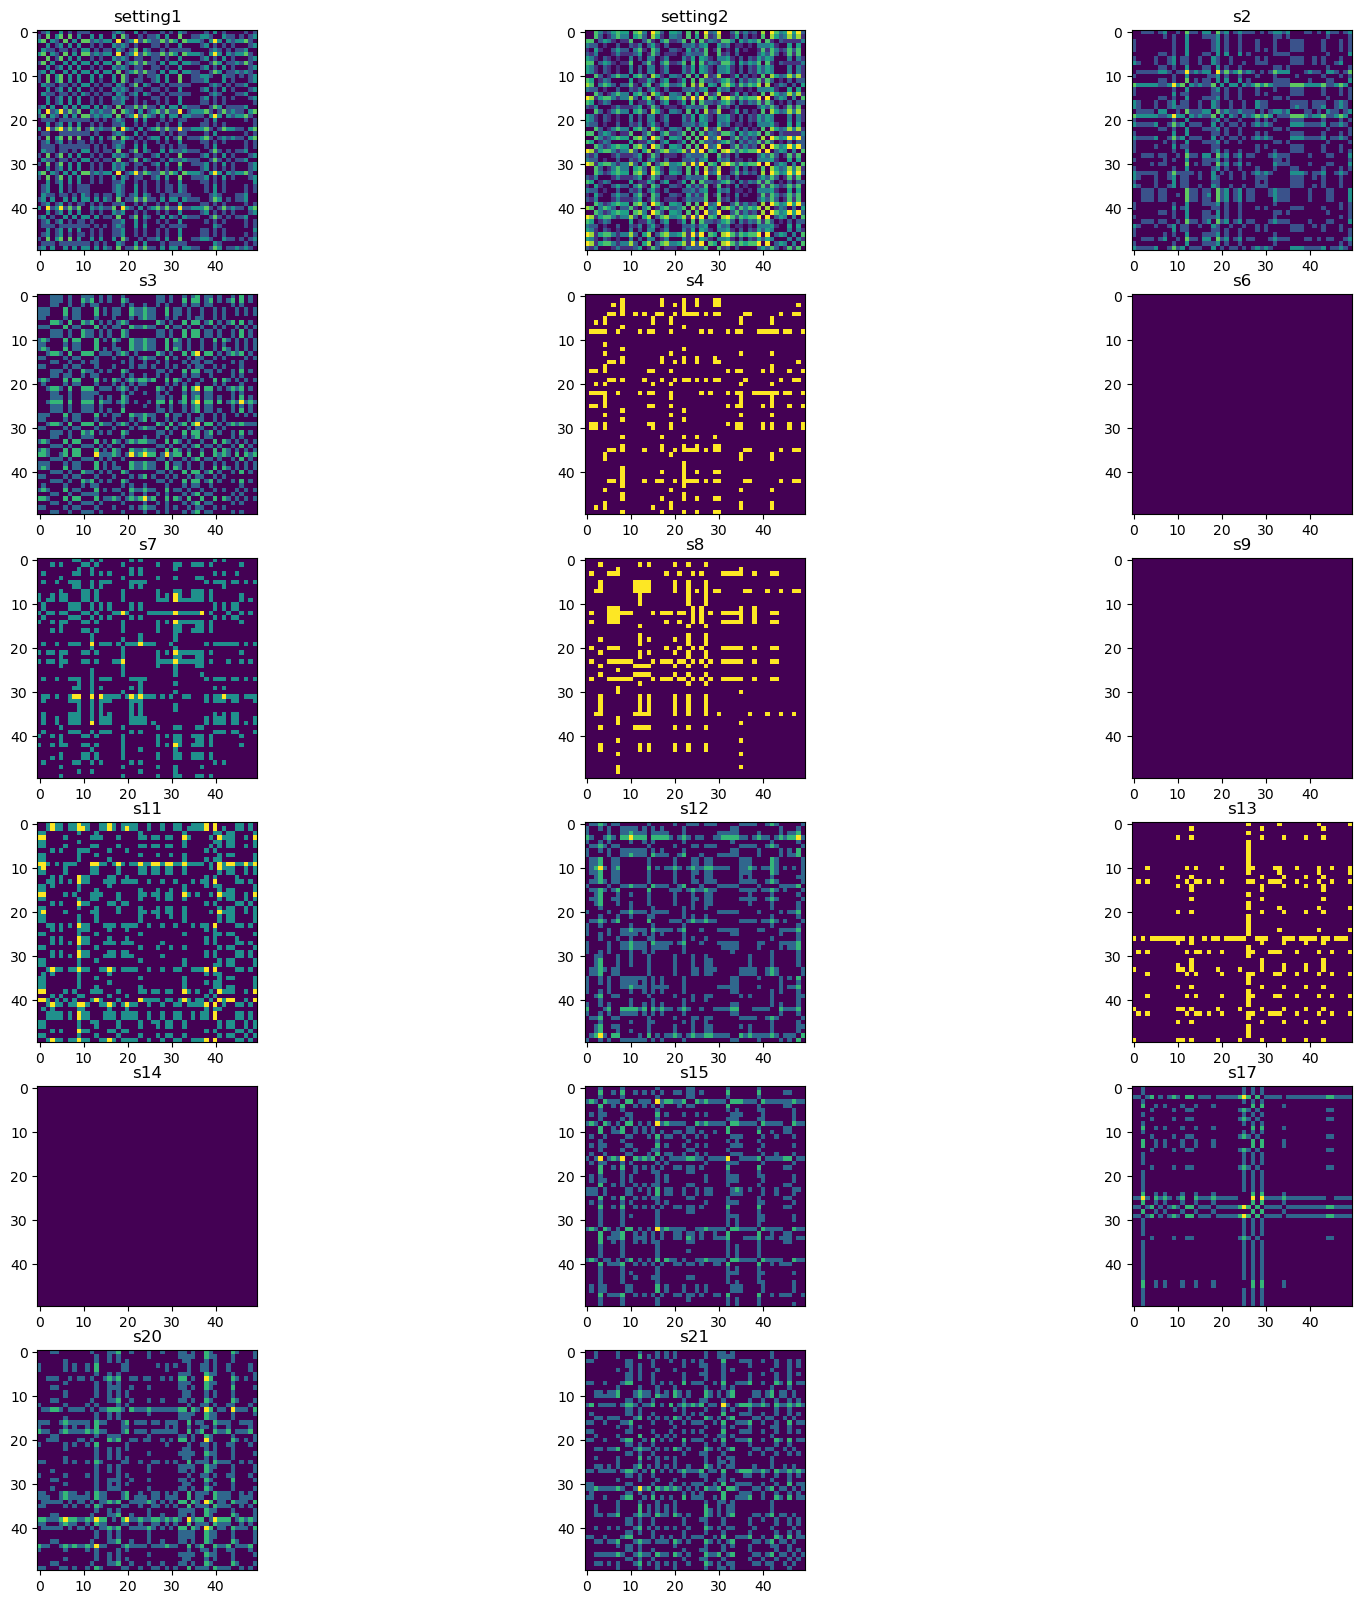

In [27]:
plt.figure(figsize=(20,20))

for i in range(0,17):
    plt.subplot(6,3,i+1)
    rec = rec_plot(x_train[0,:,i])
    plt.imshow(rec)
    plt.title(sequence_cols[i])

plt.show()

In [28]:
## Transform X training test into images #$
x_train_img = np.apply_along_axis(rec_plot, 1, x_train).astype('float16')
print(x_train_img.shape)

x_test_img = np.apply_along_axis(rec_plot, 1, x_test).astype('float16')
print(x_test_img.shape)

(15631, 50, 50, 17)
(8162, 50, 50, 17)


MODEL

In [29]:
def set_seed(seed):

    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [30]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape=(50,50,17)))
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        4928      
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         


2024-03-31 18:39:55.912324: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-31 18:39:55.912393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-31 18:39:55.912404: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-31 18:39:55.912777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-31 18:39:55.912983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 9, 9, 64)          0         
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 256)               1327360   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
          

In [31]:
set_seed(33)

es = EarlyStopping(monitor='val_accuracy', mode='auto',restore_best_weights=True, verbose=1, patience=6)

model.fit(x_train_img, y_train, batch_size=512, epochs=25, callbacks=[es],
          validation_split = 0.2, verbose = 2)

Epoch 1/25


2024-03-31 18:40:03.702113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-31 18:40:08.648359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 - 6s - loss: 1.7100 - accuracy: 0.5354 - val_loss: 0.9292 - val_accuracy: 0.7352 - 6s/epoch - 251ms/step
Epoch 2/25
25/25 - 4s - loss: 0.7586 - accuracy: 0.6983 - val_loss: 0.6105 - val_accuracy: 0.7352 - 4s/epoch - 168ms/step
Epoch 3/25
25/25 - 4s - loss: 0.5711 - accuracy: 0.7311 - val_loss: 0.3515 - val_accuracy: 0.8718 - 4s/epoch - 168ms/step
Epoch 4/25
25/25 - 4s - loss: 0.3823 - accuracy: 0.8475 - val_loss: 0.3556 - val_accuracy: 0.8254 - 4s/epoch - 166ms/step
Epoch 5/25
25/25 - 4s - loss: 0.3100 - accuracy: 0.8706 - val_loss: 0.3323 - val_accuracy: 0.8356 - 4s/epoch - 166ms/step
Epoch 6/25
25/25 - 4s - loss: 0.2918 - accuracy: 0.8736 - val_loss: 0.2623 - val_accuracy: 0.8913 - 4s/epoch - 167ms/step
Epoch 7/25
25/25 - 4s - loss: 0.2824 - accuracy: 0.8819 - val_loss: 0.2676 - val_accuracy: 0.8737 - 4s/epoch - 168ms/step
Epoch 8/25
25/25 - 4s - loss: 0.2728 - accuracy: 0.8841 - val_loss: 0.2431 - val_accuracy: 0.8948 - 4s/epoch - 168ms/step
Epoch 9/25
25/25 - 4s - loss: 0.258

In [32]:
model.evaluate(x_test_img, y_test, verbose=2)

256/256 - 2s - loss: 0.2093 - accuracy: 0.9275 - 2s/epoch - 9ms/step


[0.20934253931045532, 0.9274687767028809]

In [33]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap = plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f'

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black", fontsize = 14)
        
    
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


In [34]:
predictions = np.argmax(model.predict(x_test_img),axis=1)

 14/256 [>.............................] - ETA: 2s

2024-03-31 18:41:34.609382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


256/256 [==============================] - 3s 9ms/step


In [35]:
print(classification_report(np.where(y_test != 0)[1], predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7426
           1       0.77      0.19      0.31       676
           2       0.62      0.25      0.36        60

    accuracy                           0.93      8162
   macro avg       0.78      0.48      0.54      8162
weighted avg       0.92      0.93      0.91      8162



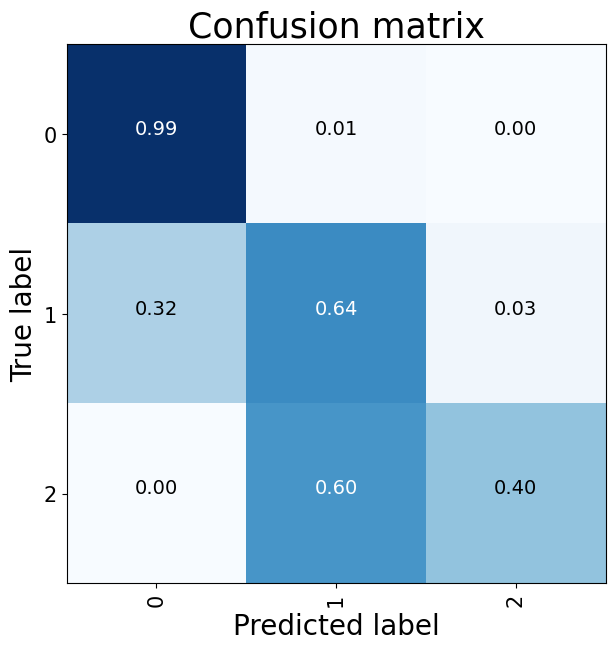

In [153]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], predictions)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()